In [1]:
import numpy as np
import torch
import os
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms, datasets, models
from random import shuffle
from torch.utils.data.sampler import SubsetRandomSampler
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
import time
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torchsummary import  summary
from torch import nn
import pandas as pd
from timeit import default_timer as timer

In [2]:
caltech_dir = '/scratch/hle/101_ObjectCategories'
list_dirs = os.listdir(caltech_dir)
list_dirs.sort()
print((list_dirs))

['Faces', 'Faces_easy', 'Leopards', 'Motorbikes', 'accordion', 'airplanes', 'anchor', 'ant', 'barrel', 'bass', 'beaver', 'binocular', 'bonsai', 'brain', 'brontosaurus', 'buddha', 'butterfly', 'camera', 'cannon', 'car_side', 'ceiling_fan', 'cellphone', 'chair', 'chandelier', 'cougar_body', 'cougar_face', 'crab', 'crayfish', 'crocodile', 'crocodile_head', 'cup', 'dalmatian', 'dollar_bill', 'dolphin', 'dragonfly', 'electric_guitar', 'elephant', 'emu', 'euphonium', 'ewer', 'ferry', 'flamingo', 'flamingo_head', 'garfield', 'gerenuk', 'gramophone', 'grand_piano', 'hawksbill', 'headphone', 'hedgehog', 'helicopter', 'ibis', 'inline_skate', 'joshua_tree', 'kangaroo', 'ketch', 'lamp', 'laptop', 'llama', 'lobster', 'lotus', 'mandolin', 'mayfly', 'menorah', 'metronome', 'minaret', 'nautilus', 'octopus', 'okapi', 'pagoda', 'panda', 'pigeon', 'pizza', 'platypus', 'pyramid', 'revolver', 'rhino', 'rooster', 'saxophone', 'schooner', 'scissors', 'scorpion', 'sea_horse', 'snoopy', 'soccer_ball', 'stapler

In [3]:
# Image transformations
image_transforms = {
    # Train uses data augmentation
    'train':
    transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),  # Image net standards
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  # Imagenet standards
    ]),
    # Validation does not use augmentation
    'val':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    # Test does not use augmentation
    'test':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [4]:
def imshow_tensor(image, ax=None, title=None):
    """Imshow for Tensor."""

    if ax is None:
        fig, ax = plt.subplots()

    # Set the color channel as the third dimension
    image = image.numpy().transpose((1, 2, 0))

    # Reverse the preprocessing steps
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean

    # Clip the image pixel values
    image = np.clip(image, 0, 1)

    ax.imshow(image)
    plt.axis('off')

    return ax, image

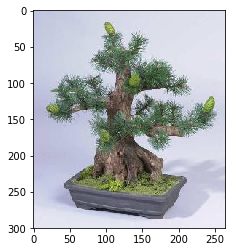

In [5]:
ex_img = Image.open('/scratch/hle/caltech_101/train/bonsai/image_0002.jpg')
plt.imshow(ex_img)

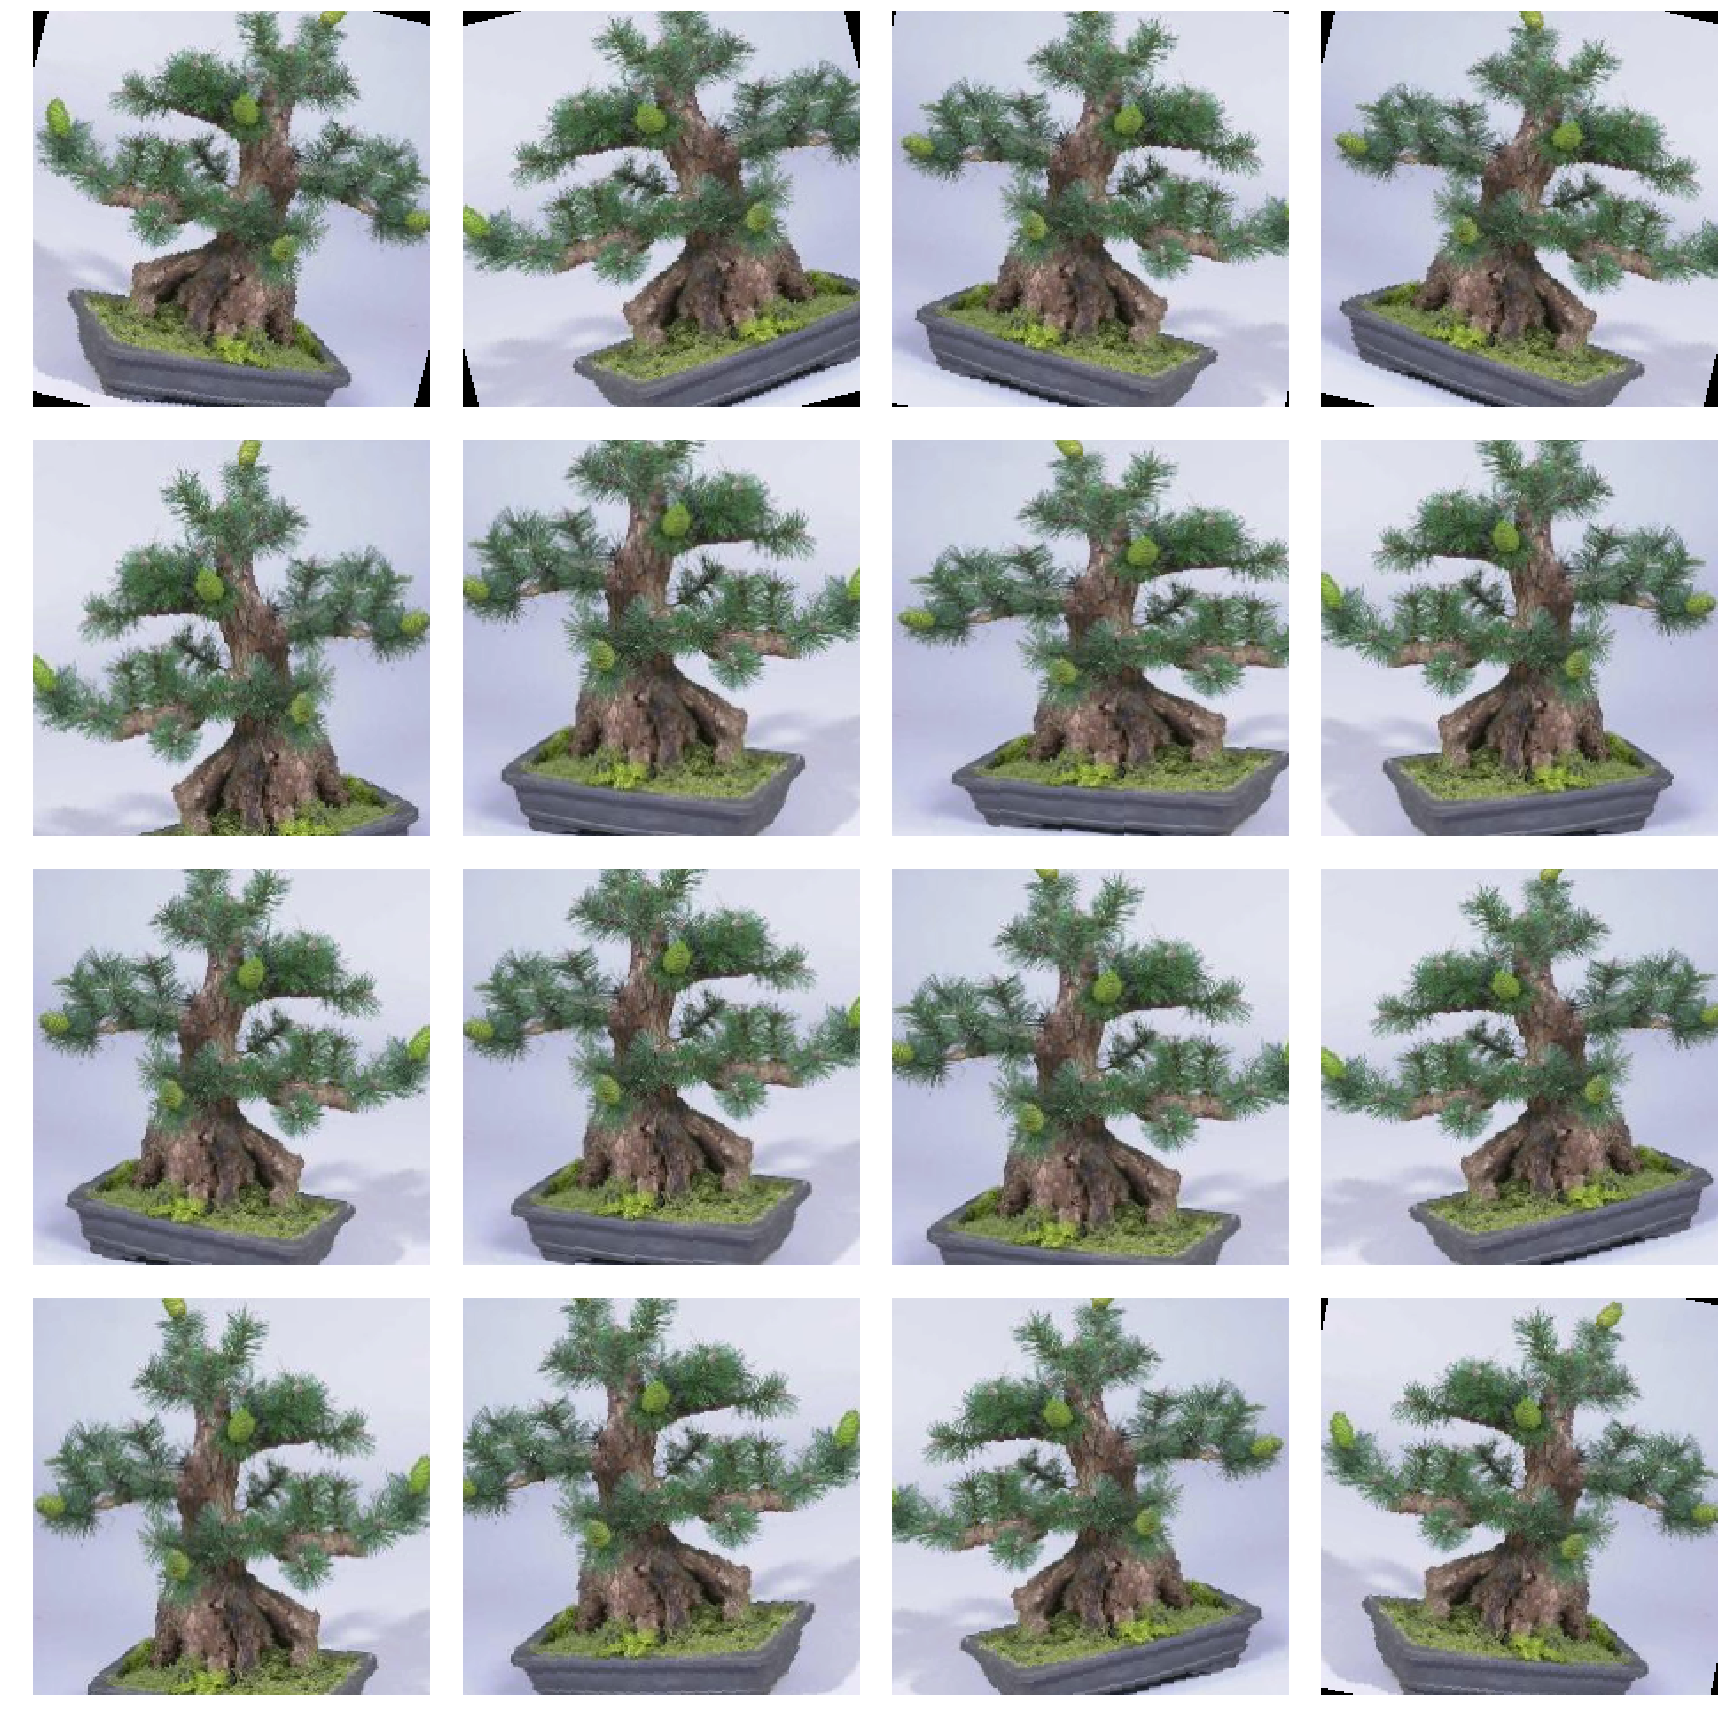

In [6]:
t = image_transforms['train']
plt.figure(figsize=(24, 24))

for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    _ = imshow_tensor(t(ex_img), ax=ax)

plt.tight_layout()


In [7]:
traindir = '/scratch/hle/caltech_101/train'
validdir = '/scratch/hle/caltech_101/valid'
testdir = '/scratch/hle/caltech_101/test'
batch_size = 128
data = {
    'train':
    datasets.ImageFolder(root=traindir, transform=image_transforms['train']),
    'val':
    datasets.ImageFolder(root=validdir, transform=image_transforms['val']),
    'test':
    datasets.ImageFolder(root=testdir, transform=image_transforms['test'])
}

# Dataloader iterators
dataloaders = {
    'train': DataLoader(data['train'], batch_size=batch_size, shuffle=True),
    'val': DataLoader(data['val'], batch_size=batch_size, shuffle=True),
    'test': DataLoader(data['test'], batch_size=batch_size, shuffle=True)
}


In [8]:
trainiter = iter(dataloaders['train'])
features, labels = next(trainiter)
features.shape, labels.shape

(torch.Size([128, 3, 224, 224]), torch.Size([128]))

In [9]:
model = models.vgg16()
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [10]:

# for param in model.parameters():
#     param.requires_grad = False

In [11]:
n_inputs = model.classifier[6].in_features

model.classifier[6] = nn.Sequential(
    nn.Linear(n_inputs, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256,101),
    nn.LogSoftmax(dim=1)
)
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace)
  (2): Dropout(p=0.5)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace)
  (5): Dropout(p=0.5)
  (6): Sequential(
    (0): Linear(in_features=4096, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4)
    (3): Linear(in_features=256, out_features=101, bias=True)
    (4): LogSoftmax()
  )
)

In [12]:

total_params = sum(p.numel() for p in model.parameters())
print('%s total parameters.' % total_params)
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print('%s training parameters.' % total_trainable_params)

135335333 total parameters.
135335333 training parameters.


In [13]:
# CUDA_VISIBLE_DEVICES="1"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model = nn.DataParallel(model)

/home/grad3/hle/.local/lib/python3.5/site-packages/torch/nn/parallel/data_parallel.py:25: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 2 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


In [14]:
# print(device)
# summary(model, input_size=(3, 224, 224), batch_size=batch_size)


In [15]:
model.class_to_idx = data['train'].class_to_idx
model.idx_to_class = {
    idx: class_
    for class_, idx in model.class_to_idx.items()
}

list(model.idx_to_class.items())[:10]

[(0, 'Faces'),
 (1, 'Faces_easy'),
 (2, 'Leopards'),
 (3, 'Motorbikes'),
 (4, 'accordion'),
 (5, 'airplanes'),
 (6, 'anchor'),
 (7, 'ant'),
 (8, 'barrel'),
 (9, 'bass')]

In [16]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters())
for p in optimizer.param_groups[0]['params']:
    if p.requires_grad:
        print(p.shape)


torch.Size([64, 3, 3, 3])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([128, 64, 3, 3])
torch.Size([128])
torch.Size([128, 128, 3, 3])
torch.Size([128])
torch.Size([256, 128, 3, 3])
torch.Size([256])
torch.Size([256, 256, 3, 3])
torch.Size([256])
torch.Size([256, 256, 3, 3])
torch.Size([256])
torch.Size([512, 256, 3, 3])
torch.Size([512])
torch.Size([512, 512, 3, 3])
torch.Size([512])
torch.Size([512, 512, 3, 3])
torch.Size([512])
torch.Size([512, 512, 3, 3])
torch.Size([512])
torch.Size([512, 512, 3, 3])
torch.Size([512])
torch.Size([512, 512, 3, 3])
torch.Size([512])
torch.Size([4096, 25088])
torch.Size([4096])
torch.Size([4096, 4096])
torch.Size([4096])
torch.Size([256, 4096])
torch.Size([256])
torch.Size([101, 256])
torch.Size([101])


In [18]:
def train(model,
          criterion,
          optimizer,
          train_loader,
          valid_loader,
          save_file_name,
          max_epochs_stop=3,
          n_epochs=20,
          print_every=2,
          attack=None):
    """Train a PyTorch Model

    Params
    --------
        model (PyTorch model): cnn to train
        criterion (PyTorch loss): objective to minimize
        optimizer (PyTorch optimizier): optimizer to compute gradients of model parameters
        train_loader (PyTorch dataloader): training dataloader to iterate through
        valid_loader (PyTorch dataloader): validation dataloader used for early stopping
        save_file_name (str ending in '.pt'): file path to save the model state dict
        max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping
        n_epochs (int): maximum number of training epochs
        print_every (int): frequency of epochs to print training stats

    Returns
    --------
        model (PyTorch model): trained cnn with best weights
        history (DataFrame): history of train and validation loss and accuracy
    """

    # Early stopping intialization
    epochs_no_improve = 0
    valid_loss_min = np.Inf

    valid_max_acc = 0
    history = []

    # Number of epochs already trained (if using loaded in model weights)
    try:
        print('Model has been trained for: %s epochs.\n' % model.epochs)
    except:
        model.epochs = 0
        print('Starting Training from Scratch.\n')

    overall_start = timer()

    # Main loop
    for epoch in range(n_epochs):

        # keep track of training and validation loss each epoch
        train_loss = 0.0
        valid_loss = 0.0
        adv_loss = 0.0

        train_acc = 0
        valid_acc = 0
        adv_acc = 0

        # Set to training
        model.train()
        start = timer()

        # Training loop
        for ii, (data, target) in enumerate(train_loader):
            # Tensors to gpu
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()

            # Clear gradients
            optimizer.zero_grad()
            # Predicted outputs are log probabilities
            if attack:
                delta = attack(model, data, target)
                output = model(data + delta)
            else:
                output = model(data)

            # Loss and backpropagation of gradients
            loss = criterion(output, target)
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Track train loss by multiplying average loss by number of examples in batch
            train_loss += loss.item() * data.size(0)

            # Calculate accuracy by finding max log probability
            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(target.data.view_as(pred))
            # Need to convert correct tensor from int to float to average
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            # Multiply average accuracy times the number of examples in batch
            train_acc += accuracy.item() * data.size(0)

            # Track training progress
            print(
                'Epoch: %s \t %s %% complete. %s seconds elapsed in epoch.' %\
                (epoch, 100 * (ii + 1) / len(train_loader), timer() - start),
                end='\r')

        # After training loops ends, start validation
        else:
            model.epochs += 1

            # Don't need to keep track of gradients

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for data, target in valid_loader:
                # Tensors to gpu
                if train_on_gpu:
                    data, target = data.cuda(), target.cuda()

                # Forward pass
                output = model(data)
                if attack:
                    delta = attack(model, data, target)
                    output_adv = model(data + delta)

                # Validation loss
                loss = criterion(output, target)
                # Multiply average loss times the number of examples in batch
                valid_loss += loss.item() * data.size(0)

                # Calculate validation accuracy
                _, pred = torch.max(output, dim=1)
                correct_tensor = pred.eq(target.data.view_as(pred))
                accuracy = torch.mean(
                    correct_tensor.type(torch.FloatTensor))
                # Multiply average accuracy times the number of examples
                valid_acc += accuracy.item() * data.size(0)

                if attack:
                    loss = criterion(output_adv, target)
                    adv_loss += loss.item() * data.size(0)
                    _, pred = torch.max(output, dim=1)
                    correct_tensor = pred.eq(target.data.view_as(pred))
                    accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
                    adv_acc += accuracy.item() * data.size(0)


            # Calculate average losses
            train_loss = train_loss / len(train_loader.dataset)
            valid_loss = valid_loss / len(valid_loader.dataset)
            if attack:
                adv_loss = adv_loss / len(valid_loader.dataset)

            # Calculate average accuracy
            train_acc = train_acc / len(train_loader.dataset)
            valid_acc = valid_acc / len(valid_loader.dataset)
            if attack:
                adv_acc = adv_acc / len(valid_loader.dataset)


            history.append([train_loss, valid_loss, adv_loss, train_acc, valid_acc, adv_acc])

            # Print training and validation results
            if (epoch + 1) % print_every == 0:
                print(
                    '\nEpoch: %s \tTraining Loss: %s \tValidation Loss: %s \tAdversarial Loss: %s' %\
                    (epoch, train_loss, valid_loss, adv_loss)
                )
                print(
                    '\t\tTraining Accuracy: %s %%\t Validation Accuracy: %s %%\t Adversarial Accuracy: %s %%' %\
                    (100 * train_acc, 100 * valid_acc, 100 * adv_acc)
                )

            # Save the model if validation loss decreases
            if valid_loss < valid_loss_min:
                # Save model
                torch.save(model.state_dict(), save_file_name)
                # Track improvement
                epochs_no_improve = 0
                valid_loss_min = valid_loss
                valid_best_acc = valid_acc
                best_epoch = epoch

            # Otherwise increment count of epochs with no improvement
            else:
                epochs_no_improve += 1
                # Trigger early stopping
                if epochs_no_improve >= max_epochs_stop:
                    print(
                        '\nEarly Stopping! Total epochs: %s. Best epoch: %s with loss: %s and acc: %s%%' %\
                        (epoch, best_epoch, valid_loss_min, 100 * valid_acc)
                    )
                    total_time = timer() - overall_start
                    print(
                        '%s total seconds elapsed. %s seconds per epoch.' % \
                        (total_time, total_time/(epoch+1))
                    )

                    # Load the best state dict
                    model.load_state_dict(torch.load(save_file_name))
                    # Attach the optimizer
                    model.optimizer = optimizer

                    # Format history
                    history = pd.DataFrame(
                        history,
                        columns=[
                            'train_loss', 'valid_loss', 'adv_loss', 'train_acc',
                            'valid_acc', 'adv_acc'
                        ])
                    return model, history

    # Attach the optimizer
    model.optimizer = optimizer
    # Record overall time and print out stats
    total_time = timer() - overall_start
    print(
        '\nBest epoch: %s with loss: %s and acc: %s %%' %\
        (best_epoch, valid_loss_min, 100 * valid_acc)
    )
    print(
        '%s total seconds elapsed. %s seconds per epoch.' %\
        (total_time, total_time / (epoch))
    )
    # Format history
    history = pd.DataFrame(
        history,
        columns=['train_loss', 'valid_loss', 'adv_loss', 'train_acc', 'valid_acc', 'adv_acc'])
    return model, history

In [19]:
def fgsm(model, X, y, epsilon=0.1):
    """ Construct FGSM adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    loss = nn.CrossEntropyLoss()(model(X + delta), y)
    loss.backward()
    return epsilon * delta.grad.detach().sign()


In [20]:
save_file_name = '/scratch/hle/data/caltech101_models/adversarial_training/vgg16-transfer-4.pt'
checkpoint_path = '/scratch/hle/data/caltech101_models/adversarial_training/vgg16-transfer-4.pth'
train_on_gpu = True
model, history = train(
    model,
    criterion,
    optimizer,
    dataloaders['train'],
    dataloaders['val'],
    save_file_name=save_file_name,
    max_epochs_stop=5,
    n_epochs=50,
    print_every=2,
    attack=fgsm)


Starting Training from Scratch.



RuntimeError: CUDA out of memory. Tried to allocate 392.00 MiB (GPU 0; 10.73 GiB total capacity; 9.34 GiB already allocated; 175.56 MiB free; 378.87 MiB cached)

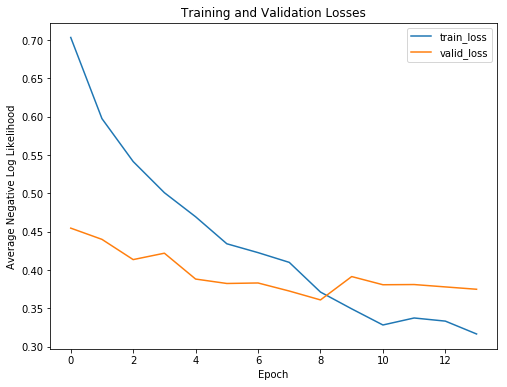

In [35]:
plt.figure(figsize=(8, 6))
for c in ['train_loss', 'valid_loss']:
    plt.plot(
        history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Negative Log Likelihood')
plt.title('Training and Validation Losses')


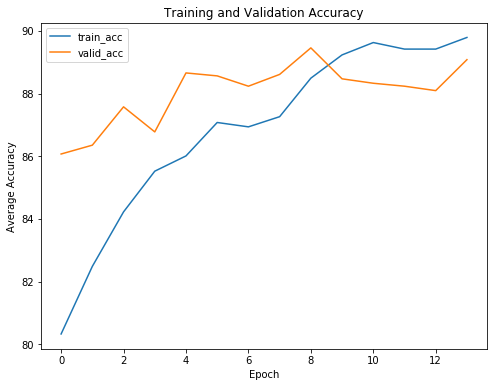

In [36]:
plt.figure(figsize=(8, 6))
for c in ['train_acc', 'valid_acc']:
    plt.plot(
        100 * history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Training and Validation Accuracy')


In [10]:
def save_checkpoint(model, path):
    """Save a PyTorch model checkpoint

    Params
    --------
        model (PyTorch model): model to save
        path (str): location to save model. Must start with `model_name-` and end in '.pth'

    Returns
    --------
        None, save the `model` to `path`

    """

    model_name = path.split('-')[0]
    assert (model_name in ['vgg16', 'resnet50'
                           ]), "Path must have the correct model name"

    # Basic details
    checkpoint = {
        'class_to_idx': model.class_to_idx,
        'idx_to_class': model.idx_to_class,
        'epochs': model.epochs,
    }

    # Extract the final classifier and the state dictionary
    if model_name == 'vgg16':
        # Check to see if model was parallelized
        if multi_gpu:
            checkpoint['classifier'] = model.module.classifier
            checkpoint['state_dict'] = model.module.state_dict()
        else:
            checkpoint['classifier'] = model.classifier
            checkpoint['state_dict'] = model.state_dict()

    elif model_name == 'resnet50':
        if multi_gpu:
            checkpoint['fc'] = model.module.fc
            checkpoint['state_dict'] = model.module.state_dict()
        else:
            checkpoint['fc'] = model.fc
            checkpoint['state_dict'] = model.state_dict()

    # Add the optimizer
    checkpoint['optimizer'] = model.optimizer
    checkpoint['optimizer_state_dict'] = model.optimizer.state_dict()

    # Save the data to the path
    torch.save(checkpoint, path)

def load_checkpoint(path):
    """Load a PyTorch model checkpoint

    Params
    --------
        path (str): saved model checkpoint. Must start with `model_name-` and end in '.pth'

    Returns
    --------
        None, save the `model` to `path`

    """

    # Get the model name
    model_name = path
    assert ('vgg16' in model_name or 'resnet50' in model_name), "Path must have the correct model name"

    # Load in checkpoint
    checkpoint = torch.load(path)
    print(checkpoint['classifier'])

    if 'vgg16' in model_name:
        model = models.vgg16(pretrained=True)
        # Make sure to set parameters as not trainable
        for param in model.parameters():
            param.requires_grad = False
        model.classifier = checkpoint['classifier']

    elif 'resnet50' in model_name:
        model = models.resnet50(pretrained=True)
        # Make sure to set parameters as not trainable
        for param in model.parameters():
            param.requires_grad = False
        model.fc = checkpoint['fc']

    # Load in the state dict
    model.load_state_dict(checkpoint['state_dict'])

    total_params = sum(p.numel() for p in model.parameters())
    print('%s total parameters.' % total_params)
    total_trainable_params = sum(
        p.numel() for p in model.parameters() if p.requires_grad)
    print('%s total gradient parameters.' % total_trainable_params)

    # Move to gpu
    if multi_gpu:
        model = nn.DataParallel(model)

    if train_on_gpu:
        print(device)
        model = model.to(device)

    # Model basics
    model.class_to_idx = checkpoint['class_to_idx']
    model.idx_to_class = checkpoint['idx_to_class']
    model.epochs = checkpoint['epochs']

    # Optimizer
    optimizer = checkpoint['optimizer']
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    return model, optimizer

In [11]:
multi_gpu = False
# save_checkpoint(model, path=checkpoint_path)

In [12]:
# below 2 lines are only needed for now. remove it later
checkpoint_path = '/scratch/hle/data/caltech101_models/vgg16-transfer-4.pth'
train_on_gpu = True
model, optimizer = load_checkpoint(path=checkpoint_path)
model = nn.DataParallel(model)

# summary(model, input_size=(3, 224, 224), batch_size=batch_size)

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace)
  (2): Dropout(p=0.5)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace)
  (5): Dropout(p=0.5)
  (6): Sequential(
    (0): Linear(in_features=4096, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4)
    (3): Linear(in_features=256, out_features=101, bias=True)
    (4): LogSoftmax()
  )
)
135335333 total parameters.
1074789 total gradient parameters.
cuda:0


/home/grad3/hle/.local/lib/python3.5/site-packages/torch/nn/parallel/data_parallel.py:25: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 2 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


In [13]:
print(checkpoint_path)

/scratch/hle/data/caltech101_models/vgg16-transfer-4.pth


In [14]:
def accuracy(output, target, topk=(1, )):
    """Compute the topk accuracy(s)"""
    if train_on_gpu:
        output = output.to(device)
        target = target.to(device)

    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        # Find the predicted classes and transpose
        _, pred = output.topk(k=maxk, dim=1, largest=True, sorted=True)
        pred = pred.t()

        # Determine predictions equal to the targets
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []

        # For each k, find the percentage of correct
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size).item())
        return res


In [15]:


testiter = iter(dataloaders['test'])
# Get a batch of testing images and labels
features, targets = next(testiter)
print(features.shape)
if train_on_gpu:
    print(accuracy(model(features.to(device)), targets, topk=(1, 5)))
else:
    print(accuracy(model(features), targets, topk=(1, 5)))



torch.Size([128, 3, 224, 224])
[85.9375, 97.65625]


In [16]:
################ ADVERSARIAL TRAINING ###############
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def fgsm(model, X, y, epsilon=0.1):
    """ Construct FGSM adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    loss = nn.CrossEntropyLoss()(model(X + delta), y)
    loss.backward()
    return epsilon * delta.grad.detach().sign()

def pgd_linf(model, X, y, epsilon=0.1, alpha=0.01, num_iter=20, randomize=False):
    """ Construct FGSM adversarial examples on the examples X"""
    if randomize:
        delta = torch.rand_like(X, requires_grad=True)
        delta.data = delta.data * 2 * epsilon - epsilon
    else:
        delta = torch.zeros_like(X, requires_grad=True)
        
    for t in range(num_iter):
        loss = nn.CrossEntropyLoss()(model(X + delta), y)
        loss.backward()
        delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach()

In [22]:
def epoch(loader, model, opt=None):
    """Standard training/evaluation epoch over the dataset"""
    total_loss, total_err = 0.,0.
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        yp = model(X)
        loss = nn.CrossEntropyLoss()(yp,y)
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()
        
        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)


def epoch_adversarial(loader, model, attack, opt=None, **kwargs):
    """Adversarial training/evaluation epoch over the dataset"""
    total_loss, total_err = 0.,0.
    for X,y in loader:
        print(X.shape)
        X,y = X.to(device), y.to(device)
        delta = attack(model, X, y, **kwargs)
        yp = model(X+delta)
        loss = nn.CrossEntropyLoss()(yp,y)
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()
        print(delta.shape)
        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

In [18]:
opt = optim.SGD(model.parameters(), lr=1e-1)
for t in range(10):
#     train_err, train_loss = epoch(dataloaders['train'], model, opt)
    test_err, test_loss = epoch(dataloaders['test'], model)
    adv_err, adv_loss = epoch_adversarial(dataloaders['test'], model, pgd_linf)
    if t == 4:
        for param_group in opt.param_groups:
            param_group["lr"] = 1e-2
    print(*("{:.6f}".format(i) for i in (test_err, adv_err)), sep="\t")
torch.save(model.state_dict(), "model_cnn.pt")

0.113292	1.000000
0.113292	1.000000
0.113292	1.000000
0.113292	1.000000
0.113292	1.000000
0.113292	1.000000
0.113292	1.000000
0.113292	1.000000
0.113292	1.000000
0.113292	1.000000


In [23]:
model, optimizer = load_checkpoint(path=checkpoint_path)
model = nn.DataParallel(model)
opt = optim.SGD(model.parameters(), lr=1e-1)
for t in range(10):
    train_err, train_loss = epoch_adversarial(dataloaders['train'], model, pgd_linf, opt)
    test_err, test_loss = epoch(dataloaders['test'], model)
    adv_err, adv_loss = epoch_adversarial(dataloaders['test'], model, pgd_linf)
    if t == 4:
        for param_group in opt.param_groups:
            param_group["lr"] = 1e-2
    print(*("{:.6f}".format(i) for i in (train_err, test_err, adv_err)), sep="\t")
torch.save(model.state_dict(), "model_cnn_robust.pt")


Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace)
  (2): Dropout(p=0.5)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace)
  (5): Dropout(p=0.5)
  (6): Sequential(
    (0): Linear(in_features=4096, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4)
    (3): Linear(in_features=256, out_features=101, bias=True)
    (4): LogSoftmax()
  )
)
135335333 total parameters.
1074789 total gradient parameters.
cuda:0


/home/grad3/hle/.local/lib/python3.5/site-packages/torch/nn/parallel/data_parallel.py:25: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 2 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


torch.Size([128, 3, 224, 224])
torch.Size([128, 3, 224, 224])
torch.Size([128, 3, 224, 224])
torch.Size([128, 3, 224, 224])
torch.Size([128, 3, 224, 224])
torch.Size([128, 3, 224, 224])
torch.Size([128, 3, 224, 224])
torch.Size([128, 3, 224, 224])
torch.Size([128, 3, 224, 224])
torch.Size([128, 3, 224, 224])
torch.Size([128, 3, 224, 224])
torch.Size([128, 3, 224, 224])
torch.Size([128, 3, 224, 224])
torch.Size([128, 3, 224, 224])
torch.Size([128, 3, 224, 224])
torch.Size([128, 3, 224, 224])
torch.Size([128, 3, 224, 224])
torch.Size([128, 3, 224, 224])
torch.Size([128, 3, 224, 224])
torch.Size([128, 3, 224, 224])
torch.Size([128, 3, 224, 224])
torch.Size([128, 3, 224, 224])
torch.Size([128, 3, 224, 224])
torch.Size([128, 3, 224, 224])
torch.Size([128, 3, 224, 224])
torch.Size([128, 3, 224, 224])
torch.Size([128, 3, 224, 224])
torch.Size([128, 3, 224, 224])
torch.Size([128, 3, 224, 224])
torch.Size([128, 3, 224, 224])
torch.Size([128, 3, 224, 224])
torch.Size([128, 3, 224, 224])
torch.Si

KeyboardInterrupt: 